In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.regnorm as regnorm
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/stackloss.csv", sep=',')

In [3]:
len(df)

21

In [4]:
df

,STACKLOSS,AIRFLOW,WATERTEMP,ACIDCONC
0,42,80,27,89
1,37,80,27,88
2,37,75,25,90
3,28,62,24,87
4,18,62,22,87
5,18,62,23,87
6,19,62,24,93
7,20,62,24,93
8,15,58,23,87
9,14,58,18,80


In [5]:
# X1 = df["AIRFLOW"].values
X2 = df["WATERTEMP"].values
# X3 = df["ACIDCONC"].values
Y = df["STACKLOSS"].values

X = X2 #np.c_[X1, X2, X3]

X = np.array(X, 'd')
Y = np.array(Y, 'd')

# Y = np.log(Y)
# X = np.log(X)

# X = np.log(X)
# Y = np.log(Y)

x_min, x_max = X.min(), X.max()
X = (X - x_min) / (x_max - x_min)
y_min, y_max = Y.min(), Y.max()
Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [6]:
from sklearn.preprocessing import scale

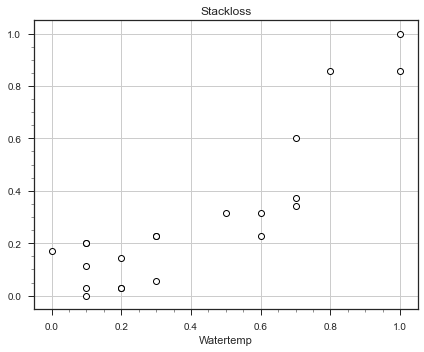

In [7]:
plt.figure(figsize=(6.0, 5.0))
# plt.subplot(1,3,1)
# plt.scatter(X1, Y, s=36, c='w', edgecolors='k', linewidths=1.)
# plt.title('Stackloss')
# plt.minorticks_on()
# plt.grid(1)
# plt.xlabel('Airflow')
# plt.ylabel('Stackloss')
# plt.subplot(1,3,2)
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
plt.title('Stackloss')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('Watertemp')
# plt.ylabel('Stackloss')
# plt.subplot(1,3,3)
# plt.scatter(X3, Y, s=36, c='w', edgecolors='k', linewidths=1.)
# plt.title('Stackloss')
# plt.minorticks_on()
# plt.grid(1)
# plt.xlabel('Acidconc')
# plt.ylabel('Stackloss')
plt.tight_layout()
plt.show()

In [8]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [9]:
sqr_norm = regnorm.SquareNorm()

In [10]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [11]:
mod_ls = model.LinearModel(1)
mod_ls.init()

[0.62726555 0.90404955] 2


K=1500 param=[-0.02894882  0.80492044]


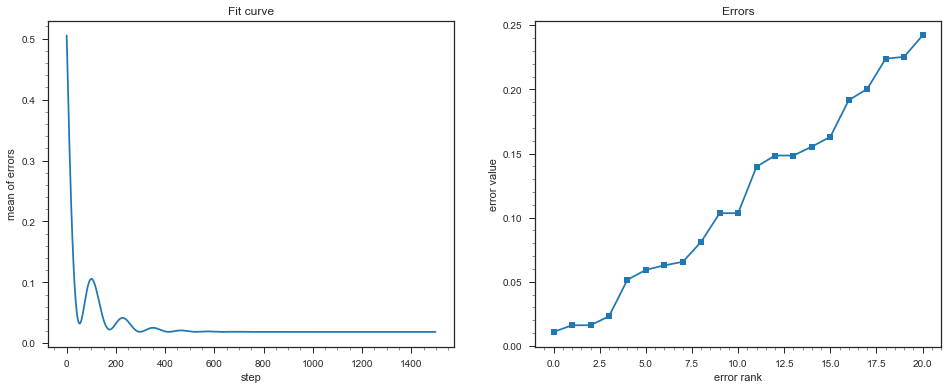

In [12]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, h=0.01, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [13]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init()

[0.94149302 0.80197701] 2


K=70 param=[0.26146154 0.15706945]


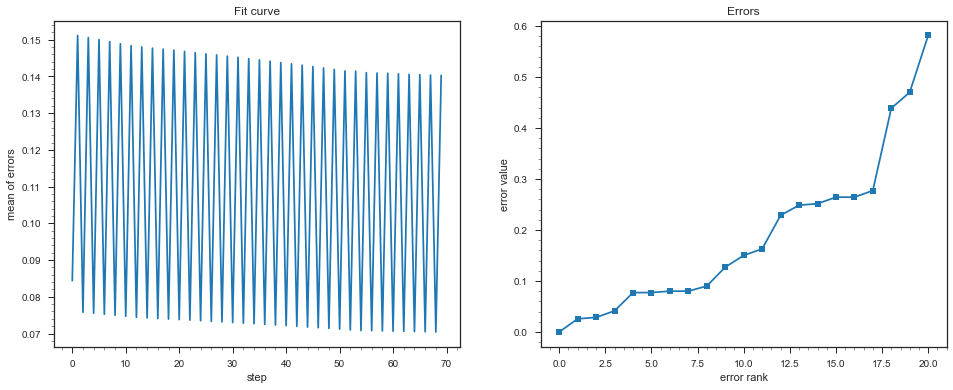

In [14]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.8, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, avrfunc=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [15]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init()

[0.64875414 0.14258775] 2


K=5 param=[0.0307392 0.4174432]


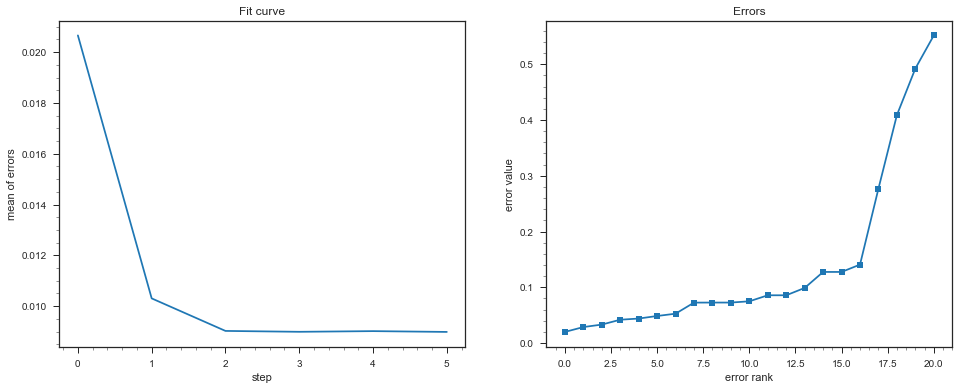

In [16]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Sqrt(0.001), alpha=0.8)
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, avrfunc=avg_wm_irls, h=0.001, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [17]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init()

[0.62715309 0.74388328] 2


K=5 param=[0.02681811 0.58188006]


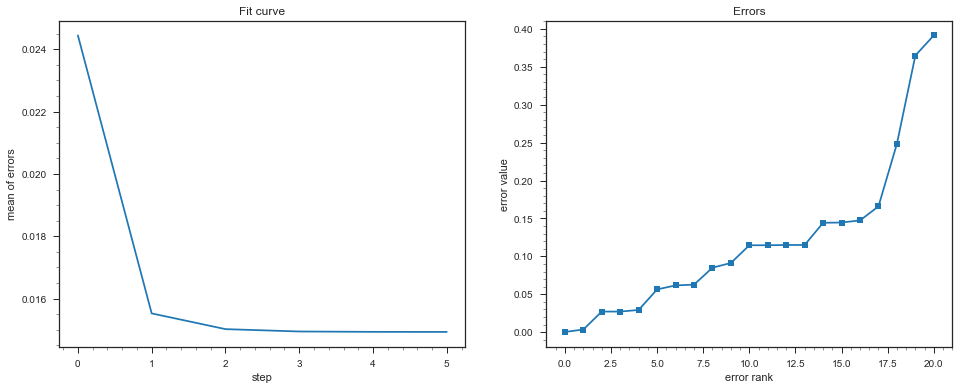

In [18]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.Sqrt(0.01), alpha=0.8)
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, avrfunc=avg_swm_irls, h=0.001, tol=1.0e-8, n_iter2=70, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [19]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [20]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init()

[0.90989234 0.2232973 ] 2


K=3 param=[-0.02898688  0.80447003]


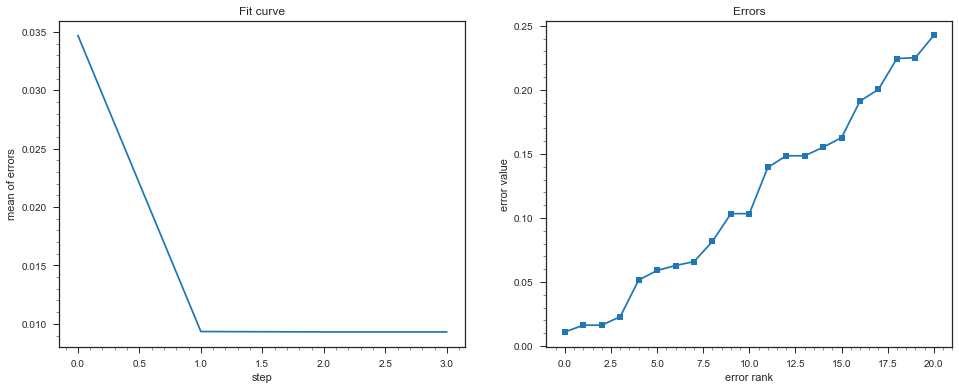

In [21]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rhofunc=func.Sqrt(1.0), h=0.001, n_iter2=70, verbose=1)
err_r_irls = curve_fit_and_errors(alg_r_irls)

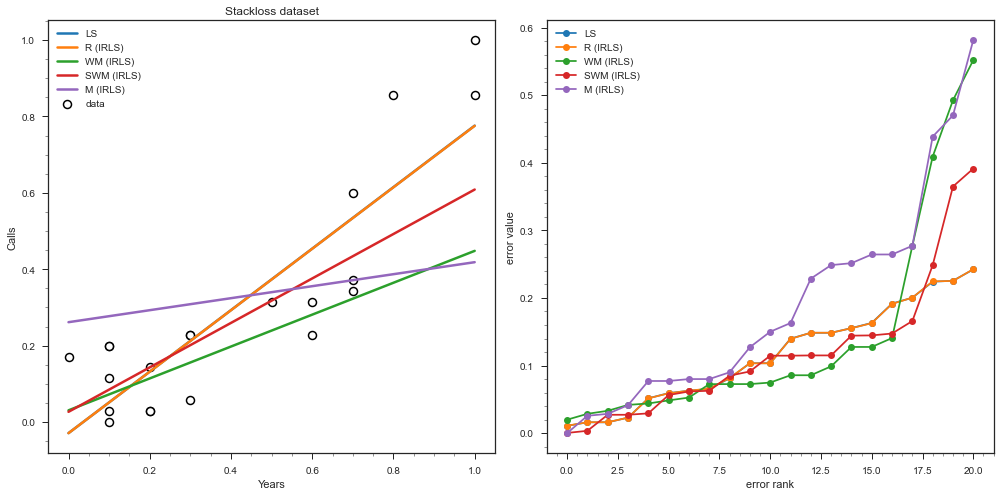

In [22]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('Stackloss dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('Years')
plt.ylabel('Calls')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [23]:
(len(Y)-6)/len(Y)

0.7142857142857143